In [1]:
import pandas as pd
import numpy as np
import sys
import os
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# add workspace directory to the path so we
# can import from .py files theree 
sys.path.insert(1, '/data/workspace_files/')
from models import ARModel

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
DATA_DIR = '/data/workspace_files/'

### Empirical Analyses

This notebook contains our main empirical analyses where we evaluate the efficacy of our sentiment indices. We use the sentiment indices to try to explain the drivers of daily realized volatility for Bitcoin and Ether, and we find a significant negative relationship between sentiment and volatility. Further analysis of all results herein is included in the report.

We start by loading the dataset created in the **Sentiment Indices and Dataset Compilation** notebook, and we define a few helper functions for running multiple regressions over different independent variables.

In [2]:
data_file = 'empirical_tests_dataset.csv'
dataset = pd.read_csv(os.path.join(DATA_DIR, data_file), index_col=0)
dataset.index = pd.to_datetime(dataset.index)

# set the index frequency - this avoids some annoying statsmodels warnings
dataset = dataset.asfreq('D')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Freq: D
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   btc_vol                     2039 non-null   float64
 1   eth_vol                     1909 non-null   float64
 2   randsent_index              2039 non-null   float64
 3   sent100_index               2039 non-null   float64
 4   btc_return                  2039 non-null   float64
 5   eth_return                  2039 non-null   float64
 6   crypto_tweets               2039 non-null   int64  
 7   ln_crypto_tweets            2039 non-null   float64
 8   vix                         2039 non-null   float64
 9   randsent_index_diff         2039 non-null   float64
 10  sent100_index_diff          2039 non-null   float64
 11  set                         2039 non-null   object 
 12  randsent_index_scaled       2039 non-null   float64
 13  sent100

In [3]:
def get_data(df, set, cols):
    """Helper function for getting data from the dataset DataFrame."""
    if cols is None:
        return
    rows = df.index if (set == 'all') else (df['set'] == set)

    return df.loc[rows, cols]

def get_field_dict(coin, index):
    """Create the field dictionary for a given coin/index. 
    This determines which regressions are run on which variables.
    """
    sent_index = index + '_scaled'
    sent_index_diff = index + '_diff_scaled'
    coin_returns = coin + '_return_scaled'
    fields = {
        '(1)': [sent_index],
        '(2)': [sent_index_diff],
        '(3)': [sent_index, 'ln_crypto_tweets_scaled'],
        '(4)': [sent_index, 'ln_crypto_tweets_scaled', 'vix_scaled'],
        '(5)': [sent_index, 'ln_crypto_tweets_scaled', coin_returns],
        '(6)': [
            sent_index,
            sent_index_diff,
            'ln_crypto_tweets_scaled',
            'vix_scaled',
            coin_returns
        ],
        'AR(p)': None
    }

    return fields

def run_regressions(dataset, coin, index, model, verbose=True):
    """Run regressions for the given dataset, coin, and sentiment index."""
    model_fields = get_field_dict(coin, index)
    coin_vol = coin + '_vol'

    summary = {}
    bic = {}
    ins_pred = {}
    oos_pred = {}

    for model_name, fields in model_fields.items():
        y = get_data(dataset, 'train', coin_vol)
        x = get_data(dataset, 'train', fields)

        if y.isna().sum() > 0:
            y = y.dropna()
            if x is not None:
                x = x.loc[y.index, :]

        model.fit(y=y, x=x, cov_type='HC0')
        summary[(model_name, 'coef')] = model.res.params
        summary[(model_name, 'z')] = model.res.tvalues
        bic[model_name] = model.res.bic

        y_test = get_data(dataset, 'test', coin_vol)
        x_test = get_data(dataset, 'test', fields)

        ins_pred[model_name] = model.predict(y=y, x=x)
        oos_pred[model_name] = model.predict(y=y_test, x=x_test)

        if verbose:
            print('')
            print(' {} '.format(model_name).center(95, '='))
            print(model.res.summary())

    results = {
        'coin': coin,
        'index': index,
        'summary': summary,
        'bic': bic,
        'ins_pred': ins_pred,
        'oos_pred': oos_pred
    }

    return results

In [4]:
def regression_table(results):
    """Tabulate the regression results from the run_regression function."""
    summary = pd.DataFrame(results['summary'])

    summary.rename(
        index={
            'intercept': 'Intercept', 
            'btc_vol.L1': 'Realized Vol.L1',
            'eth_vol.L1': 'Realized Vol.L1',
            'randsent_index_scaled': 'RandSent Index',
            'sent100_index_scaled': 'Sent100 Index',
            'randsent_index_diff_scaled': '$\Delta$RandSent Index',
            'sent100_index_diff_scaled': '$\Delta$Sent100 Index',
            'ln_crypto_tweets_scaled': 'Crypto Tweets',
            'vix_scaled': 'VIX',
            'btc_return_scaled': 'BTC Return',
            'eth_return_scaled': 'ETH Return'
        },
        inplace=True
    )
    
    # reshape the table
    summary = summary.melt(ignore_index=False)
    summary = summary.pivot(index=(summary.index, 'variable_1'), columns='variable_0')
    summary.columns = summary.columns.droplevel(0)

    col_order = [
        '(1)',
        '(2)',
        '(3)',
        '(4)',
        '(5)',
        '(6)'
    ]
    row_order_temp = [
        'Intercept', 
        'Realized Vol.L1',
        'RandSent Index',
        'Sent100 Index',
        '$\Delta$RandSent Index',
        '$\Delta$Sent100 Index',
        'Crypto Tweets',
        'VIX',
        'BTC Return',
        'ETH Return'
    ]
    row_order = []
    for row in row_order_temp:
        if row in summary.index:
            row_order.append((row, 'coef'))
            row_order.append((row, 'z'))

    summary = summary.loc[row_order, col_order]

    return summary.round(4)

def rmse_table(results, ins_max_len=None, oos_max_len=None):
    """Tabulate the RMSE results from the run_regression function."""
    coin_vol = results['coin'] + '_vol'
    ins_pred = results['ins_pred']
    oos_pred = results['oos_pred']

    ins_len = min([x.shape[0] for x in ins_pred.values()])
    oos_len = min([x.shape[0] for x in oos_pred.values()])
    ins_len = min(ins_len, ins_max_len)
    oos_len = min(oos_len, oos_max_len)

    ins_pred = {key: value[-ins_len:] 
                for key, value in ins_pred.items()}
    oos_pred = {key: value[-oos_len:] 
                for key, value in oos_pred.items()}
                
    btc_vol_train = get_data(dataset, 'train', coin_vol)[-ins_len:]
    btc_vol_test = get_data(dataset, 'test', coin_vol)[-oos_len:]

    mse = pd.DataFrame({
        'In-Sample': {key: mean_squared_error(btc_vol_train, prediction)
                      for key, prediction in ins_pred.items()},
        'Out-of-Sample': {key: mean_squared_error(btc_vol_test, prediction)
                          for key, prediction in oos_pred.items()}
    })
    rmse = np.sqrt(mse).round(4)

    return rmse

Next, we run regressions for each set of control variables for each coin and sentiment index, for a total of 4 sets of 6 regressions. All results presented below are included in the report.

In [5]:
coin = 'btc'
index = 'randsent_index'

model = ARModel(lags=1)
results = run_regressions(dataset, coin, index, model)
regression_table(results)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                btc_vol   No. Observations:                 1674
Model:                   AutoReg-X(1)   Log Likelihood                4101.795
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Sun, 03 Oct 2021   AIC                             -7.737
Time:                        21:07:44   BIC                             -7.724
Sample:                    01-02-2016   HQIC                            -7.732
                         - 07-31-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.0119      0.002      7.653      0.000       0.009       0.015
b

variable_0 
 (1) 
 (2) 
 (3) 
 (4) 
 (5) 
 (6) 
 
 
 
 variable_1 
 
 
 
 
 
 
 
 
 
 
 Intercept 
 coef 
 0.0119 
 0.0110 
 0.0159 
 0.0160 
 0.0158 
 0.0153 
 
 
 z 
 7.6532 
 7.2269 
 10.1235 
 10.2398 
 9.9729 
 9.8650 
 
 
 Realized Vol.L1 
 coef 
 0.6421 
 0.6700 
 0.5215 
 0.5197 
 0.5240 
 0.5404 
 
 
 z 
 12.5938 
 13.2163 
 10.5778 
 10.6413 
 10.4898 
 10.9920 
 
 
 RandSent Index 
 coef 
 -0.0028 
 NaN 
 -0.0073 
 -0.0073 
 -0.0069 
 -0.0060 
 
 
 z 
 -3.9248 
 NaN 
 -7.3340 
 -7.4213 
 -7.4745 
 -6.5498 
 
 
 $\Delta$RandSent Index 
 coef 
 NaN 
 -0.0049 
 NaN 
 NaN 
 NaN 
 -0.0018 
 
 
 z 
 NaN 
 -6.4236 
 NaN 
 NaN 
 NaN 
 -3.0959 
 
 
 Crypto Tweets 
 coef 
 NaN 
 NaN 
 0.0092 
 0.0091 
 0.0089 
 0.0083 
 
 
 z 
 NaN 
 NaN 
 9.0904 
 9.0517 
 8.9195 
 8.2059 
 
 
 VIX 
 coef 
 NaN 
 NaN 
 NaN 
 0.0006 
 NaN 
 0.0006 
 
 
 z 
 NaN 
 NaN 
 NaN 
 0.6844 
 NaN 
 0.6662 
 
 
 BTC Return 
 coef 
 NaN 
 NaN 
 NaN 
 NaN 
 -0.0016 
 -0.0012 
 
 
 z 
 NaN 
 NaN 
 NaN 
 NaN 
 -1.4478 
 -1.1471

In [6]:
rmse_table(results, ins_max_len=1670, oos_max_len=361)

,In-Sample,Out-of-Sample
(1),0.0208,0.0193
(2),0.0204,0.0184
(3),0.0194,0.0164
(4),0.0194,0.0164
(5),0.0194,0.0161
(6),0.0193,0.0164
AR(p),0.0210,0.0187


In [7]:
model = ARModel(lags=4)
results = run_regressions(dataset, coin, index, model)
rmse_table(results, ins_max_len=1670, oos_max_len=361)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                btc_vol   No. Observations:                 1674
Model:                   AutoReg-X(4)   Log Likelihood                4154.860
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Sun, 03 Oct 2021   AIC                             -7.805
Time:                        21:07:45   BIC                             -7.783
Sample:                    01-05-2016   HQIC                            -7.797
                         - 07-31-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.0074      0.001      7.169      0.000       0.005       0.009
b

,In-Sample,Out-of-Sample
(1),0.0201,0.0183
(2),0.0198,0.0175
(3),0.0190,0.0158
(4),0.0190,0.0158
(5),0.0189,0.0155
(6),0.0189,0.0157
AR(p),0.0203,0.0178


In [8]:
coin = 'btc'
index = 'sent100_index'

model = ARModel(lags=1)
results = run_regressions(dataset, coin, index, model)
regression_table(results)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                btc_vol   No. Observations:                 1674
Model:                   AutoReg-X(1)   Log Likelihood                4096.515
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Sun, 03 Oct 2021   AIC                             -7.730
Time:                        21:07:45   BIC                             -7.717
Sample:                    01-02-2016   HQIC                            -7.726
                         - 07-31-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0123      0.002      7.908      0.000       0.009       0.015
btc_

variable_0 
 (1) 
 (2) 
 (3) 
 (4) 
 (5) 
 (6) 
 
 
 
 variable_1 
 
 
 
 
 
 
 
 
 
 
 Intercept 
 coef 
 0.0123 
 0.0117 
 0.0148 
 0.0148 
 0.0148 
 0.0148 
 
 
 z 
 7.9083 
 7.3874 
 9.0839 
 9.0523 
 9.0046 
 8.9334 
 
 
 Realized Vol.L1 
 coef 
 0.6298 
 0.6487 
 0.5551 
 0.5542 
 0.5550 
 0.5545 
 
 
 z 
 12.3546 
 12.4298 
 10.6704 
 10.5885 
 10.5437 
 10.4288 
 
 
 Sent100 Index 
 coef 
 -0.0023 
 NaN 
 -0.0031 
 -0.0034 
 -0.0030 
 -0.0032 
 
 
 z 
 -3.3666 
 NaN 
 -4.4062 
 -5.4594 
 -4.5769 
 -5.2629 
 
 
 $\Delta$Sent100 Index 
 coef 
 NaN 
 -0.0011 
 NaN 
 NaN 
 NaN 
 -0.0008 
 
 
 z 
 NaN 
 -1.9065 
 NaN 
 NaN 
 NaN 
 -1.4172 
 
 
 Crypto Tweets 
 coef 
 NaN 
 NaN 
 0.0057 
 0.0058 
 0.0056 
 0.0057 
 
 
 z 
 NaN 
 NaN 
 7.6698 
 7.4666 
 7.5592 
 7.3146 
 
 
 VIX 
 coef 
 NaN 
 NaN 
 NaN 
 -0.0007 
 NaN 
 -0.0007 
 
 
 z 
 NaN 
 NaN 
 NaN 
 -0.6143 
 NaN 
 -0.7088 
 
 
 BTC Return 
 coef 
 NaN 
 NaN 
 NaN 
 NaN 
 -0.0026 
 -0.0026 
 
 
 z 
 NaN 
 NaN 
 NaN 
 NaN 
 -2.2303 
 -2.2009

In [9]:
rmse_table(results, ins_max_len=1670, oos_max_len=361)

,In-Sample,Out-of-Sample
(1),0.0209,0.0184
(2),0.0210,0.0186
(3),0.0202,0.0210
(4),0.0202,0.0210
(5),0.0200,0.0203
(6),0.0200,0.0204
AR(p),0.0210,0.0187


In [10]:
model = ARModel(lags=4)
results = run_regressions(dataset, coin, index, model)
rmse_table(results, ins_max_len=1670, oos_max_len=361)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                btc_vol   No. Observations:                 1674
Model:                   AutoReg-X(4)   Log Likelihood                4140.318
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Sun, 03 Oct 2021   AIC                             -7.788
Time:                        21:07:45   BIC                             -7.765
Sample:                    01-05-2016   HQIC                            -7.780
                         - 07-31-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0079      0.001      7.724      0.000       0.006       0.010
btc_

,In-Sample,Out-of-Sample
(1),0.0203,0.0177
(2),0.0203,0.0177
(3),0.0198,0.0196
(4),0.0198,0.0197
(5),0.0196,0.0189
(6),0.0196,0.0190
AR(p),0.0203,0.0178


In [11]:
coin = 'eth'
index = 'randsent_index'

model = ARModel(lags=1)
results = run_regressions(dataset, coin, index, model)
regression_table(results)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                eth_vol   No. Observations:                 1544
Model:                   AutoReg-X(1)   Log Likelihood                3121.192
Method:               Conditional MLE   S.D. of innovations              0.032
Date:                Sun, 03 Oct 2021   AIC                             -6.878
Time:                        21:07:46   BIC                             -6.864
Sample:                    05-11-2016   HQIC                            -6.873
                         - 07-31-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.0246      0.003      7.663      0.000       0.018       0.031
e

variable_0 
 (1) 
 (2) 
 (3) 
 (4) 
 (5) 
 (6) 
 
 
 
 variable_1 
 
 
 
 
 
 
 
 
 
 
 Intercept 
 coef 
 0.0246 
 0.0213 
 0.0248 
 0.0248 
 0.0246 
 0.0243 
 
 
 z 
 7.6632 
 6.6317 
 7.8141 
 7.8361 
 7.6972 
 7.4986 
 
 
 Realized Vol.L1 
 coef 
 0.5386 
 0.6025 
 0.5269 
 0.5269 
 0.5321 
 0.5378 
 
 
 z 
 8.3421 
 9.1432 
 8.1895 
 8.1926 
 8.2010 
 8.1288 
 
 
 RandSent Index 
 coef 
 -0.0073 
 NaN 
 -0.0102 
 -0.0102 
 -0.0093 
 -0.0088 
 
 
 z 
 -6.6064 
 NaN 
 -6.9226 
 -6.9658 
 -6.6547 
 -5.9738 
 
 
 $\Delta$RandSent Index 
 coef 
 NaN 
 -0.0054 
 NaN 
 NaN 
 NaN 
 -0.0012 
 
 
 z 
 NaN 
 -4.6071 
 NaN 
 NaN 
 NaN 
 -1.0658 
 
 
 Crypto Tweets 
 coef 
 NaN 
 NaN 
 0.0057 
 0.0057 
 0.0050 
 0.0048 
 
 
 z 
 NaN 
 NaN 
 4.2899 
 4.3810 
 3.9266 
 3.6372 
 
 
 VIX 
 coef 
 NaN 
 NaN 
 NaN 
 -0.0003 
 NaN 
 -0.0004 
 
 
 z 
 NaN 
 NaN 
 NaN 
 -0.2720 
 NaN 
 -0.3723 
 
 
 ETH Return 
 coef 
 NaN 
 NaN 
 NaN 
 NaN 
 -0.0039 
 -0.0037 
 
 
 z 
 NaN 
 NaN 
 NaN 
 NaN 
 -3.4086 
 -3.2739

In [12]:
rmse_table(results, ins_max_len=1670, oos_max_len=361)

,In-Sample,Out-of-Sample
(1),0.0320,0.0244
(2),0.0323,0.0217
(3),0.0316,0.0202
(4),0.0316,0.0202
(5),0.0314,0.0190
(6),0.0314,0.0191
AR(p),0.0328,0.0225


In [13]:
model = ARModel(lags=4)
results = run_regressions(dataset, coin, index, model)
rmse_table(results, ins_max_len=1670, oos_max_len=361)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                eth_vol   No. Observations:                 1544
Model:                   AutoReg-X(4)   Log Likelihood                3150.769
Method:               Conditional MLE   S.D. of innovations              0.031
Date:                Sun, 03 Oct 2021   AIC                             -6.921
Time:                        21:07:46   BIC                             -6.896
Sample:                    05-14-2016   HQIC                            -6.912
                         - 07-31-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.0186      0.002      8.090      0.000       0.014       0.023
e

,In-Sample,Out-of-Sample
(1),0.0313,0.0231
(2),0.0314,0.0211
(3),0.0309,0.0195
(4),0.0309,0.0196
(5),0.0306,0.0184
(6),0.0306,0.0184
AR(p),0.0318,0.0219


In [14]:
coin = 'eth'
index = 'sent100_index'

model = ARModel(lags=1)
results = run_regressions(dataset, coin, index, model)
regression_table(results)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                eth_vol   No. Observations:                 1544
Model:                   AutoReg-X(1)   Log Likelihood                3090.895
Method:               Conditional MLE   S.D. of innovations              0.033
Date:                Sun, 03 Oct 2021   AIC                             -6.839
Time:                        21:07:46   BIC                             -6.825
Sample:                    05-11-2016   HQIC                            -6.834
                         - 07-31-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0225      0.003      7.083      0.000       0.016       0.029
eth_

variable_0 
 (1) 
 (2) 
 (3) 
 (4) 
 (5) 
 (6) 
 
 
 
 variable_1 
 
 
 
 
 
 
 
 
 
 
 Intercept 
 coef 
 0.0225 
 0.0218 
 0.0224 
 0.0225 
 0.0224 
 0.0225 
 
 
 z 
 7.0825 
 6.8829 
 7.0623 
 7.0645 
 7.0584 
 7.0426 
 
 
 Realized Vol.L1 
 coef 
 0.5777 
 0.5919 
 0.5790 
 0.5759 
 0.5785 
 0.5752 
 
 
 z 
 8.9032 
 9.1106 
 8.9459 
 8.8115 
 8.9065 
 8.7519 
 
 
 Sent100 Index 
 coef 
 -0.0031 
 NaN 
 -0.0032 
 -0.0040 
 -0.0030 
 -0.0038 
 
 
 z 
 -3.3061 
 NaN 
 -3.3221 
 -4.1798 
 -3.3150 
 -3.9115 
 
 
 $\Delta$Sent100 Index 
 coef 
 NaN 
 -0.0013 
 NaN 
 NaN 
 NaN 
 -0.0004 
 
 
 z 
 NaN 
 -1.3797 
 NaN 
 NaN 
 NaN 
 -0.3819 
 
 
 Crypto Tweets 
 coef 
 NaN 
 NaN 
 0.0010 
 0.0012 
 0.0008 
 0.0011 
 
 
 z 
 NaN 
 NaN 
 0.9681 
 1.2245 
 0.7643 
 1.0657 
 
 
 VIX 
 coef 
 NaN 
 NaN 
 NaN 
 -0.0017 
 NaN 
 -0.0019 
 
 
 z 
 NaN 
 NaN 
 NaN 
 -1.1786 
 NaN 
 -1.3698 
 
 
 ETH Return 
 coef 
 NaN 
 NaN 
 NaN 
 NaN 
 -0.0053 
 -0.0053 
 
 
 z 
 NaN 
 NaN 
 NaN 
 NaN 
 -4.2261 
 -4.2096

In [15]:
rmse_table(results, ins_max_len=1670, oos_max_len=361)

,In-Sample,Out-of-Sample
(1),0.0326,0.0226
(2),0.0328,0.0224
(3),0.0326,0.0227
(4),0.0326,0.0226
(5),0.0322,0.0209
(6),0.0321,0.0209
AR(p),0.0328,0.0225


In [16]:
model = ARModel(lags=4)
results = run_regressions(dataset, coin, index, model)
rmse_table(results, ins_max_len=1670, oos_max_len=361)


============================================= (1) =============================================
                            AutoReg Model Results                             
Dep. Variable:                eth_vol   No. Observations:                 1544
Model:                   AutoReg-X(4)   Log Likelihood                3128.016
Method:               Conditional MLE   S.D. of innovations              0.032
Date:                Sun, 03 Oct 2021   AIC                             -6.891
Time:                        21:07:47   BIC                             -6.867
Sample:                    05-14-2016   HQIC                            -6.882
                         - 07-31-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0161      0.002      7.157      0.000       0.012       0.020
eth_

,In-Sample,Out-of-Sample
(1),0.0317,0.0220
(2),0.0318,0.0218
(3),0.0317,0.0223
(4),0.0317,0.0223
(5),0.0313,0.0206
(6),0.0312,0.0206
AR(p),0.0318,0.0219


Finally, we use a Kalman filter model to estimate the time varying coefficients for the Bitcoin volatility and RandSent Index model. See the report for detailed explanation of the model and results.

In [17]:
# Kalman Filter to estimate time varying coefficients
y = dataset['btc_vol']
x = np.stack([dataset['randsent_index_scaled'], 
              dataset['ln_crypto_tweets_scaled']], axis=1)
x = sm.add_constant(x)

# using an AR(2) for the lagged variables results in better convergence
# the sentiment coefficient trend is unchanged between p=1 and p=2
kf = SARIMAX(y, exog=x, order=(2,0,0), mle_regression=False, 
             time_varying_regression=True, hamilton_representation=True)
res = kf.fit(max_iter=100)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                btc_vol   No. Observations:                 2039
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5351.697
Date:                Sun, 03 Oct 2021   AIC                         -10691.395
Time:                        21:07:50   BIC                         -10657.682
Sample:                    01-01-2016   HQIC                        -10679.027
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4701      0.014     32.963      0.000       0.442       0.498
ar.L2          0.1707      0.017      9.949      0.000       0.137       0.204
var.const   1.439e-06   6.31e-07      2.281      0.0

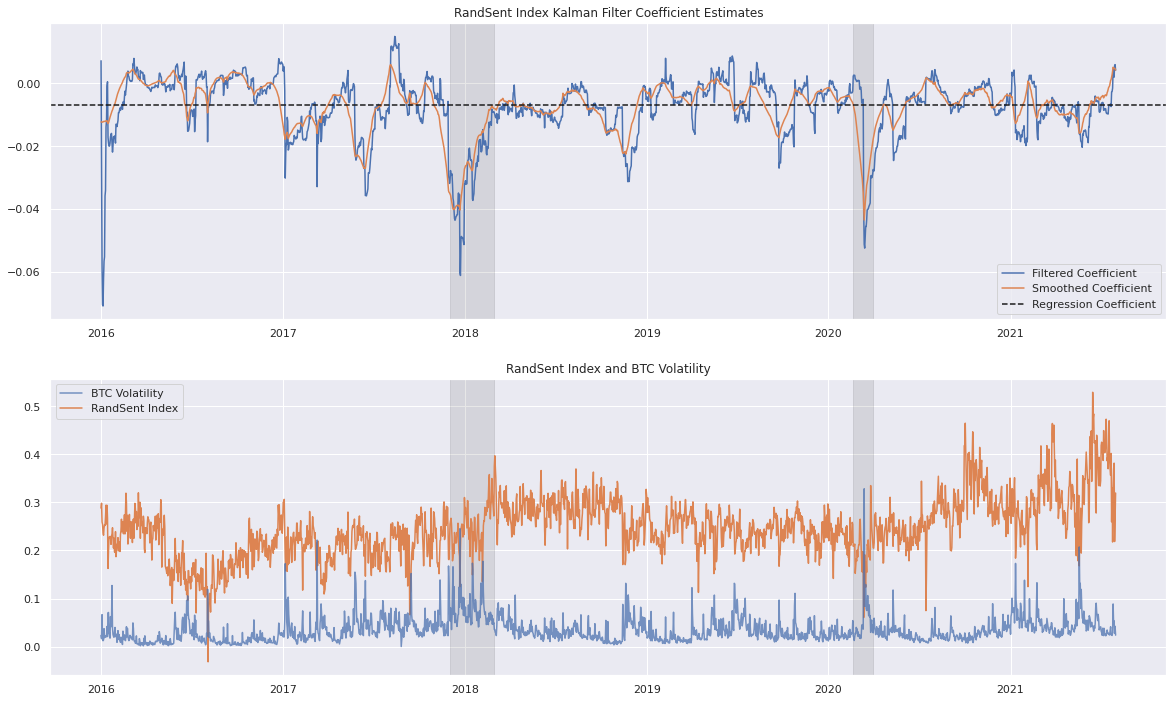

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

x_axis = dataset.index

ax[0].plot(x_axis, res.filtered_state[-2, :], label='Filtered Coefficient')
ax[0].plot(x_axis, res.smoothed_state[-2, :], label='Smoothed Coefficient')
ax[0].axhline(-0.007, label='Regression Coefficient', color='k', linestyle='--')
ax[0].legend(loc='lower right')
ax[0].set_title('RandSent Index Kalman Filter Coefficient Estimates')

ax[1].plot(x_axis, dataset['btc_vol'], label='BTC Volatility', 
           alpha=0.75, zorder=2)
ax[1].plot(x_axis, dataset['randsent_index'], label='RandSent Index',
           alpha=1.0, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_title('RandSent Index and BTC Volatility')

# 2017/2018 crash
dates = (pd.to_datetime('2017-12-01'), pd.to_datetime('2018-02-28'))
ax[0].axvspan(*dates, color='k', alpha=0.1)
ax[1].axvspan(*dates, color='k', alpha=0.1)

# 2020 COVID crash
dates = (pd.to_datetime('2020-02-19'), pd.to_datetime('2020-03-31'))
ax[0].axvspan(*dates, color='k', alpha=0.1)
ax[1].axvspan(*dates, color='k', alpha=0.1)

# save for report
fig.savefig('kalman_filter_coefs.png')
plt.show()